In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
import seaborn as sns
from math import sqrt
from numba import njit, float64
from numba.experimental import jitclass
from ing_theme_matplotlib import mpl_style

mpl_style(True)

In [2]:
@njit
def AM(a, b):
    """
    arithmetic mean
    """
    return (a + b) / 2


@njit
def GM(a, b):
    """
    geometric mean
    """
    return sqrt(a * b)

In [3]:
########################################
#              CPMM class              #
########################################

CPMM_spec = [("P", float64), ("L", float64), ("fee", float64)]


@jitclass(CPMM_spec)
class CPMM:
    def __init__(self, p=2500.0, l=10_000.0, f=0.003):
        self.P = p
        self.L = l
        self.fee = f

    def xReserves(self):
        return self.L / sqrt(self.P)

    def yReserves(self):
        return self.L * sqrt(self.P)

    def tradeToPrice(self, extP):
        newP = self.P
        newL = self.L

        # price is high enough
        if extP * (1 - self.fee) > self.P:
            reportP = extP * (1 - self.fee)

            newL = self.L * sqrt(
                1 / (1 - self.fee) - self.fee / (1 - self.fee) * sqrt(self.P / reportP)
            )
            newP = reportP / (1 - self.fee) - self.fee / (1 - self.fee) * sqrt(
                self.P * reportP
            )

        # price is low enough
        if extP < self.P * (1 - self.fee):
            reportP = extP / (1 - self.fee)

            newL = self.L * sqrt(
                1 / (1 - self.fee) - self.fee / (1 - self.fee) * sqrt(reportP / self.P)
            )
            newP = (
                reportP
                * (1 - self.fee)
                * sqrt(self.P)
                / (sqrt(self.P) - self.fee * sqrt(reportP))
            )

        # price is within nonprofitable range
        else:
            return (0, 0)

        # calculate the change in reserves
        delta_x = newL / sqrt(newP) - self.L / sqrt(self.P)
        delta_y = newL * sqrt(newP) - self.L * sqrt(self.P)

        # update state
        self.P = newP
        self.L = newL

        return (delta_x, delta_y)

In [4]:
########################################
#              DPAMM class             #
########################################
DPAMM_spec = [
    ("refP", float64),
    ("refL", float64),
    ("mainP", float64),
    ("mainL", float64),
    ("default_fee", float64),
    ("fee_limit", float64),
    ("buy_fee", float64),
    ("sell_fee", float64),
]


@jitclass(DPAMM_spec)
class DPAMM:
    def __init__(self, p=2500.0, l=10_000.0, f=0.001, f_limit=0.01):
        self.refP = p
        self.refL = l / 10
        self.mainP = p
        self.mainL = l - self.refL
        self.default_fee = f
        self.fee_limit = f_limit
        self.buy_fee = f
        self.sell_fee = f

    def xReserves(self):
        return self.refL / sqrt(self.refP) + self.mainL / sqrt(self.mainP)

    def yReserves(self):
        return self.refL * sqrt(self.refP) + self.mainL * sqrt(self.mainP)

    def tradeToPrice(self, extP):
        # update buy_fee and sell_fee
        self.buy_fee = max(
            min(1 - (self.mainP / self.refP) * (1 - self.default_fee), self.fee_limit),
            0,
        )
        self.sell_fee = max(
            min(1 - (self.refP / self.mainP) * (1 - self.default_fee), self.fee_limit),
            0,
        )

        # reference pool is fee-less so always be updated
        newRefP = extP
        newRefL = self.refL

        delta_x = newRefL / sqrt(newRefP) - self.refL / sqrt(self.refP)
        delta_y = newRefL * sqrt(newRefP) - self.refL * sqrt(self.refP)

        self.refP = newRefP
        self.refL = newRefL

        # main pool will be conditionally updated
        newMainP = self.mainP
        newMainL = self.mainL

        # price is high enough
        if extP * (1 - self.buy_fee) > self.mainP:
            reportP = extP * (1 - self.buy_fee)

            newMainL = self.mainL * sqrt(
                1 / (1 - self.buy_fee)
                - self.buy_fee / (1 - self.buy_fee) * sqrt(self.mainP / reportP)
            )
            newMainP = reportP / (1 - self.buy_fee) - self.buy_fee / (
                1 - self.buy_fee
            ) * sqrt(self.mainP * reportP)

        # price is low enough
        if extP < self.mainP * (1 - self.sell_fee):
            reportP = extP / (1 - self.sell_fee)

            newMainL = self.mainL * sqrt(
                1 / (1 - self.sell_fee)
                - self.sell_fee / (1 - self.sell_fee) * sqrt(reportP / self.mainP)
            )
            newMainP = (
                reportP
                * (1 - self.sell_fee)
                * sqrt(self.mainP)
                / (sqrt(self.mainP) - self.sell_fee * sqrt(reportP))
            )

        # price is within nonprofitable range
        else:
            return (delta_x, delta_y)

        # calculate the change in reserves
        delta_x += newMainL / sqrt(newMainP) - self.mainL / sqrt(self.mainP)
        delta_y += newMainL * sqrt(newMainP) - self.mainL * sqrt(self.mainP)

        # update state
        self.mainP = newMainP
        self.mainL = newMainL

        return (delta_x, delta_y)

In [5]:
########################################
#              FMAMM class             #
########################################

FMAMM_spec = [("P", float64), ("L", float64), ("fee", float64)]


@jitclass(FMAMM_spec)
class FMAMM:
    def __init__(self, p=2500.0, l=10_000.0, f=0.0015):
        self.P = p
        self.L = l
        self.fee = f

    def xReserves(self):
        return self.L / sqrt(self.P)

    def yReserves(self):
        return self.L * sqrt(self.P)

    def tradeToPrice(self, extP):
        newP = self.P
        newL = self.L

        # price is high enough
        if extP * (1 - self.fee) / (1 + self.fee) > self.P:
            newP = sqrt(
                self.P * extP * (1 - self.fee) / (1 + self.fee)
            )  # optimal price for arbitrageur
            newL = self.L * AM(self.P, newP) / GM(self.P, newP)  # FMAMM logic
            +self.fee * self.L * (
                (sqrt(extP * (1 - self.fee) / (1 + self.fee)) - sqrt(self.P))
                / sqrt(newP)
            ) / 2  # fee

        # price is low enough
        elif extP * (1 + self.fee) / (1 - self.fee) < self.P:
            newP = sqrt(
                self.P * extP * (1 + self.fee) / (1 - self.fee)
            )  # optimal price for arbitrageur
            newL = self.L * AM(self.P, newP) / GM(self.P, newP)  # FMAMM logic
            +self.fee * self.L * sqrt(newP) * (
                1 / sqrt(extP * (1 + self.fee) / (1 - self.fee)) - 1 / sqrt(self.P)
            ) / 2  # fee

        # price is within nonprofitable range
        else:
            return (0, 0)

        # calculate the change in reserves
        delta_x = newL / sqrt(newP) - self.L / sqrt(self.P)
        delta_y = newL * sqrt(newP) - self.L * sqrt(self.P)

        # update state
        self.P = newP
        self.L = newL

        return (delta_x, delta_y)

In [6]:
@njit
def run_simulations(
    daily_std,
    blocks_per_day,
    paths,
    days=1,
):
    # lvr for CPMM, DPAMM, FMAMM with 15 bps fee, FMAMM with 0 bps fee
    results = np.zeros((8, paths))

    for jj in range(paths):
        amm0 = CPMM(2500.0, 10_000.0, 0.003)
        amm1 = DPAMM(2500.0, 10_000.0, 0.003, 0.01)
        amm2 = FMAMM(2500.0, 10_000.0, 0.0015)
        amm3 = FMAMM(2500.0, 10_000.0, 0.0)

        # save the initial price
        p0 = amm0.P

        sigma = daily_std / np.sqrt(blocks_per_day)  # vol between blocks
        T = int(days * blocks_per_day)

        # Generate a GBM path for prices
        z = np.cumsum(np.random.normal(0.0, sigma, T))
        # Note that we are adding a risk-neutral drift, so that the price process is a martingale
        prices = np.exp(z - (np.arange(T) * sigma**2) / 2)
        prices = prices / prices[0] * p0

        lvr0 = 0.0
        lvr1 = 0.0
        lvr2 = 0.0
        lvr3 = 0.0

        for i in range(T):
            # CPMM
            val0 = prices[i] * amm0.xReserves() + amm0.yReserves()
            x0, y0 = amm0.tradeToPrice(prices[i])
            lvr0 += -(prices[i] * x0 + y0) / val0

            # DPAMM
            val1 = prices[i] * amm1.xReserves() + amm1.yReserves()
            x1, y1 = amm1.tradeToPrice(prices[i])
            lvr1 += -(prices[i] * x1 + y1) / val1

            # FMAMM with 15 bps fee
            val2 = prices[i] * amm2.xReserves() + amm2.yReserves()
            x2, y2 = amm2.tradeToPrice(prices[i])
            lvr2 += -(prices[i] * x2 + y2) / val2

            # FMAMM with 0 bps fee
            val3 = prices[i] * amm3.xReserves() + amm3.yReserves()
            x3, y3 = amm3.tradeToPrice(prices[i])
            lvr3 += -(prices[i] * x3 + y3) / val3

        results[:, jj] = [
            lvr0 / days,
            lvr1 / days,
            lvr2 / days,
            lvr3 / days,
            prices[T - 1] * amm0.xReserves() + amm0.yReserves(),
            prices[T - 1] * amm1.xReserves() + amm1.yReserves(),
            prices[T - 1] * amm2.xReserves() + amm2.yReserves(),
            prices[T - 1] * amm3.xReserves() + amm3.yReserves(),
        ]

    return results

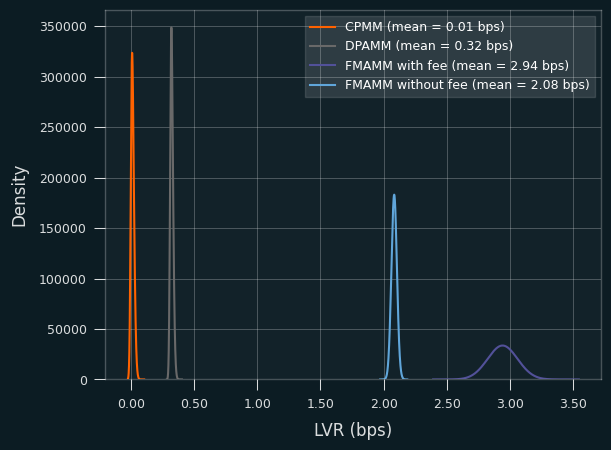

In [7]:
daily_std = 0.05
block_time = 12  # 12 for Mainnet, 5 for Gnosis, 1 for L2s
blocks_per_day = 24 * 60 * 60 / block_time
paths = 10_000
days = 7

results = run_simulations(daily_std, blocks_per_day, paths, days)

# sns.set_style("darkgrid")
# sns.set_palette("autumn")

bw_adjust = 5
means = np.mean(results, 1)

# Plotting with the specified adjustments
ax = sns.kdeplot(
    data=results[0, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[0] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[1, :],
    bw_adjust=bw_adjust,
    label=f"DPAMM (mean = {means[1] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[2, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM with fee (mean = {means[2] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[3, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM without fee (mean = {means[3] * 10**4:.2f} bps)",
)

ax.set(xlabel="LVR (bps)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick * 10000:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()

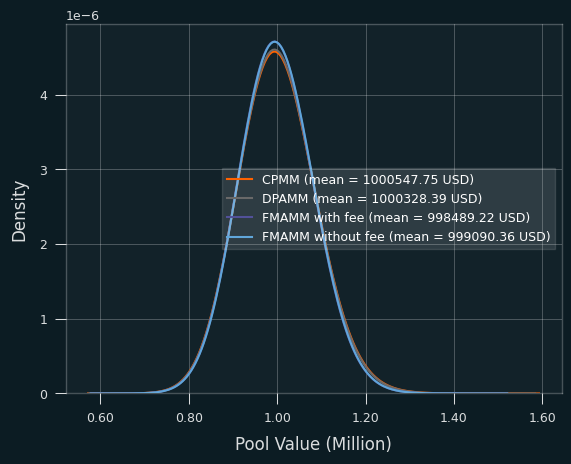

In [8]:
# Plotting with the specified adjustments
ax = sns.kdeplot(
    data=results[4, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[4]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[5, :],
    bw_adjust=bw_adjust,
    label=f"DPAMM (mean = {means[5]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[6, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM with fee (mean = {means[6]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[7, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM without fee (mean = {means[7]:.2f} USD)",
)

ax.set(xlabel="Pool Value (Million)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick / 10**6:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()